# CellAssign results

Notebook showing cellAssign results with new taxonomy from Nick.

`cell_types` composed in https://github.com/NIH-CARD/brain-taxonomy

```python
cell_types = [
    "oligo", #Oligo
    "opc", #OPC
    "glutamatergic", #ExN
    "gabergic", #InN
    "astrocyte", #Astro
    "immune", #MG
    "blood", #VC
]
```

----


Outline:

- setup:  imports, helper_functions, data path definitions
- get predictions (fit `cellassign` model)
- assess predictions
    - clean vs. full set of samples
    - cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
    - repititions / seeds


## setup  
- imports 
- helper_functions 
- data path definitions

In [1]:
import sys
import os

import scanpy as sc
import anndata as ad
from pathlib import Path
import scipy.sparse as sp
import pandas as pd
import numpy as np
import scvi

# %%
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(".."))


In [2]:
XYLENA2_RAW_PATH = "data/scdata/xylena_raw"
XYLENA2_PATH = "data/scdata/xylena"

# FULL data is both "clean" (train+test) and "dirty" samples which were originally left out of the dataset
XYLENA2_FULL = "xyl2_full.h5ad"


CELLASSIGN_SIMPLE_MARKERS_TABLE = "cellassign_simple_markers.csv"
CELLASSIGN_SIMPLE2_MARKERS_TABLE = "cellassign_simple2_markers.csv"
CELLASSIGN_SIMPLE3_MARKERS_TABLE = "cellassign_simple3_markers.csv"


In [3]:
root_path = Path.cwd().parent
data_path = root_path / XYLENA2_PATH
raw_data_path = root_path / XYLENA2_RAW_PATH

markers_path = raw_data_path / CELLASSIGN_SIMPLE3_MARKERS_TABLE
markers = pd.read_csv(markers_path, index_col=0)

In [4]:
# helper functions
def get_cell_types(adata, markers, batch_key=None, noise=None, seed=9627):
    """ """
    #  2. copy for cellassign
    # bdata = adata[:, markers.index].copy() #
    bdata = adata[:, adata.var.index.isin(markers.index)].copy()

    #  3. get size_factor and noise .  NOTE: it is imperitive to compute lib_size on the full data
    lib_size = adata.X.sum(1)  # type: ignore
    bdata.obs["size_factor"] = lib_size / np.mean(lib_size)

    #  4. model = CellAssign(bdata, marker_genes)
    scvi.external.CellAssign.setup_anndata(
        bdata,
        size_factor_key="size_factor",
        # batch_key="sample",
        batch_key=batch_key,
        layer=None,  #'counts',
        continuous_covariate_keys=noise,
    )

    #  5. model.train()
    # NOTE: highly dependent on seed... which may be a way for us to estimate the uncertainty of the ground truth prediction
    scvi.settings.seed = seed
    model = scvi.external.CellAssign(bdata, markers)
    model.train()  # use default training parameters

    #  6. model.predict()
    preds = model.predict()
    preds["cellassign_types"] = preds.idxmax(axis=1).values

    if "cell_type" not in bdata.obs_keys():
        preds["cell_type"] = "NONE"
    else:
        preds["cell_type"] = bdata.obs["cell_type"].values
    preds["sample"] = bdata.obs["sample"].values
    preds["cell"] = bdata.obs.index.values
    preds.index = preds["cell"].values

    return preds, model


def plot_confusion(
    df: pd.DataFrame,
    title_caption: str = "Confusion matrix",
    pred_key: str = "cellassign_types_A",
    cell_type_key: str = "cellassign_types_B",
):
    """Plot confusion matrix of predictions. This version is slooooow (6 seconds)

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    pred_key : str
        Key in `adata.obs` where predictions are stored. Default is `pred`.
    cell_type_key : str
        Key in `adata.obs` where cell types are stored. Default is `cell_type`.
    model_name : str
        Name of model. Default is `LBL8R`.
    title_str : str
        Additional string to add to title. Default is `""`.
    fig_dir : Path | str
        Directory to save figure to. Default is `None`.

    Returns
    -------
    None

    """
    # Calculate precision, recall, and F1-score
    prec = precision_score(df[cell_type_key], df[pred_key], average="macro")
    rec = recall_score(df[cell_type_key], df[pred_key], average="macro")
    f1 = f1_score(df[cell_type_key], df[pred_key], average="macro")
    acc = (df[pred_key] == df[cell_type_key]).mean()
    confusion_matrix = pd.crosstab(
        df[pred_key],
        df[cell_type_key],
        rownames=[f"Prediction {pred_key}"],
        colnames=[f"Ground truth {cell_type_key}"],
    )
    confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        confusion_matrix,
        cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
        ax=ax,
        square=True,
        cbar_kws=dict(shrink=0.4, aspect=12),
    )
    title_str = f"{acc=:3f}:  {prec=:3f}: {rec=:3f}: {f1=:3f})"
    ax.set_title(title_str.split(":"))
    plt.suptitle(title_caption)
    plt.tight_layout()


# %%


def print_count_subset(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )
    key = f"{labs[1]}pct_"
    summary[key] = (
        100
        * merged_predictions.cellassign_types_B.value_counts()
        / merged_predictions.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}_"
    summary[key] = merged_predictions.cellassign_types_B.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(f"   (underscore `_` indicates samples matched to {labs[0]} samples)")
    print(summary)

    return summary

def print_count_group(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}"
    summary[key] = predictionsB.cellassign_types.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(summary)

    return summary

In [ ]:
predictions


In [9]:

def print_count_ground_truth(
    predictionsA: pd.DataFrame, labs: str = "A"
):

    summary = pd.DataFrame()

    summary[labs] = predictionsA.cell_type.value_counts()

    key = f"{labs}_ca"
    summary[key] = predictionsA.cellassign_types.value_counts()

    key = f"{labs}pct"
    summary[key] = (
        100 * predictionsA.cell_type.value_counts() / predictionsA.shape[0]
    )

    key = f"{labs}_capct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )

    print(
        f" N samples {labs}= {predictionsA.shape[0]}"
    )
    return summary



def assess_ca_v_ground_truth(predictions, 
                    titlestr,     
                    pred_key: str = "cellassign_types",
                    cell_type_key: str = "cell_type"):
    """
    conmpare the `cell_type` vs `cellassign_type`

    first split into 'unknowns' and 'knowns' cells based on `predictions["ground_truth"] != "UNKNOWN" (knowns)`

    then calculate the confusion matrix for the "knowns":
    """
        
    
    unknowns = predictions[predictions[cell_type_key] == "UNKNOWN" ]
    knowns = predictions[predictions[cell_type_key] !=  "UNKNOWN" ] 
    100*unknowns.cellassign_types.value_counts()/unknowns.shape[0]
    print_count_ground_truth(knowns, labs=f"-{titlestr}")

    print_count_ground_truth(knowns, labs=f"uknowns-{titlestr}")

    unknowns.shape


## get predictions
fit `cellasign` model

> (skipping) `retrain=False`


In [6]:
retrain = False

noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]  # aka "noise"

########################
# 0. LOAD TRAIN DATA
########################

if retrain:

    filen = data_path / XYLENA2_FULL
    adata = ad.read_h5ad(filen)

    # In[ ]:
    train_test_samp = adata.obs["train"] | adata.obs["test"]

    for samp_set in ["full", "clean"]:
        bdata = adata[train_test_samp] if samp_set == "clean" else adata

        # for rep in [6]:
        #     seed = 9627
        for rep in range(5):  # [0,1,2,3,4] have different seeds  [5,6,7] are the same
            if rep in [2, 3, 4]:
                seed = 9627
            else:
                seed = rep
            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=noise, seed=seed
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_noise_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_noise_cellassign"
            model.save(modelname, overwrite=True)

            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=None
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_cellassign"
            model.save(modelname, overwrite=True)

## assess predictions

compare:    
- clean vs. full set of samples
- cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
- repititions / seeds

In [8]:
if not retrain:
    filen = data_path / XYLENA2_FULL
    adata = ad.read_h5ad(filen)


### Full and Clean sets  vanilla vs. continuous_covariates ("_noise")

In [37]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 3

for samp_set in ["full", "clean"]:
    noise = "_noise"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    noise = ""
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
    )
    # print_count_group(predictionsA, predictionsB, labs=[A, B])
    # plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")


    print_count_ground_truth(predictionsA,A)
    plot_confusion(predictionsA, title_caption=f"{A} vs. `ground_truth`", pred_key="cellassign_types_A", cell_type_key="cell_type_A")

    print_count_ground_truth(predictionsB,B)
    plot_confusion(predictionsB, title_caption=f"{B} vs. `ground_truth`", pred_key="cellassign_types_B", cell_type_key="cell_type_B")


 N samples full3_noise= 2012744


KeyError: 'cell_type_A'

: 

/opt/conda/envs/gcp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/tmp/ipykernel_3343388/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


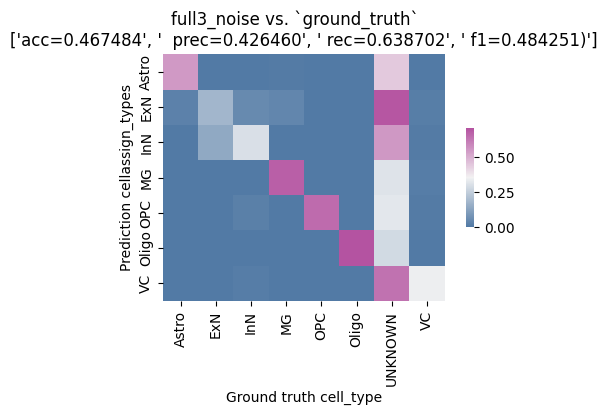

In [33]:
plot_confusion(predictionsA, title_caption=f"{A} vs. `ground_truth`", pred_key="cellassign_types", cell_type_key="cell_type")


In [36]:
unknowns = predictionsA[predictionsA.cell_type=="UNKNOWN"]
knowns = predictionsA[predictionsA.cell_type!="UNKNOWN"]
100*unknowns.cellassign_types.value_counts()/unknowns.shape[0]
unknowns.shape

(940332, 11)

In [26]:

print_count_ground_truth(predictionsB,B)
# plot_confusion(predictionsB, title_caption=f"{B} vs. `ground_truth`", pred_key="cellassign_types_B", cell_type_key="cell_type_B")


 N samples full3= 2012744


,full3,full3pct,full3_capct
cell_type,,,
UNKNOWN,NaN,46.718907,NaN
Oligo,743366.0,25.912585,36.932963
ExN,22425.0,7.676585,1.114151
InN,31226.0,6.025903,1.551414
Astro,165352.0,5.363424,8.215252
MG,84385.0,4.016706,4.192535
OPC,167014.0,3.623014,8.297826
VC,798976.0,0.662876,39.695858


/opt/conda/envs/gcp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/tmp/ipykernel_3343388/1574413659.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


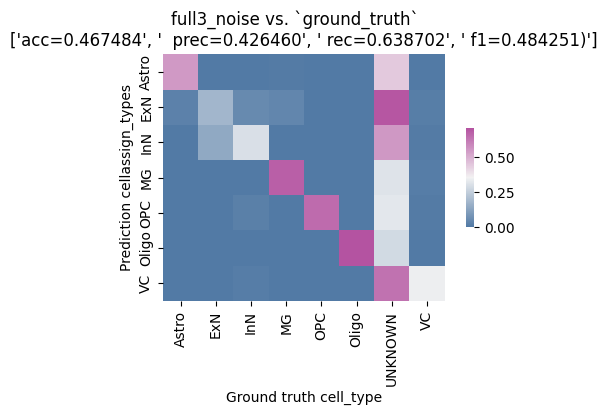

In [28]:
predictionsA

plot_confusion(predictionsA, title_caption=f"{A} vs. `ground_truth`", pred_key="cellassign_types", cell_type_key="cell_type")


#### implications

For the "clean" samples choosing batch correction with continuous covariates (`noise`) doesn't make much of a difference.  However for the "full" set of samples it is crucial.  It seems reasonabl the the "dirty" samples drive this need for more involved batch correction.


### Vanilla and "Noise" sets  Clean vs. Full ("_noise")

 N samples clean3_noise= 1000247, N samples full3_noise= 2012744
   (underscore `_` indicates samples matched to clean3_noise samples)
                  clean3_noisepct  full3_noisepct  full3_noisepct_  \
cellassign_types                                                     
Oligo                   43.796182       36.530925        43.821976   
InN                     39.173924       14.732773        13.761401   
Astro                    6.914592        8.340306         6.979876   
OPC                      5.270098        5.479336         5.289993   
MG                       4.645752        4.037374         4.645153   
VC                       0.182955        0.269880         0.240341   
ExN                      0.016496       30.609407        25.261260   

                  clean3_noise  full3_noise_  
cellassign_types                              
Oligo                   438070        438328  
InN                     391836        137648  
Astro                    69163         69816  

/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3= 1000247, N samples full3= 2012744
   (underscore `_` indicates samples matched to clean3 samples)
                  clean3pct   full3pct  full3pct_  clean3  full3_
cellassign_types                                                 
Oligo             44.004131  36.932963  44.300458  440150  443114
InN               28.802086   1.551414   1.593206  288092   15936
ExN                9.911452   1.114151   1.448342   99139   14487
Astro              7.038262   8.215252   6.900696   70400   69024
OPC                5.275197   8.297826   7.740288   52765   77422
MG                 4.663348   4.192535   4.823209   46645   48244
VC                 0.305525  39.695858  33.193801    3056  332020


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


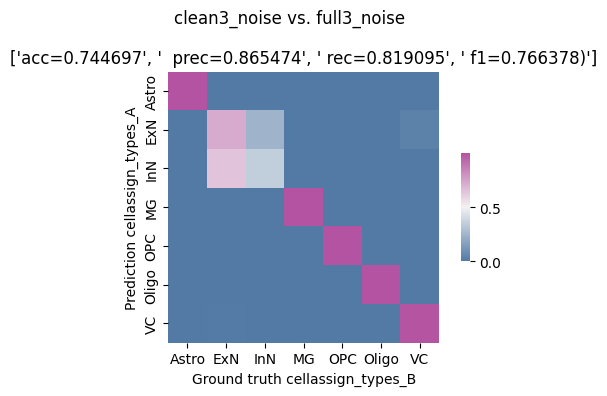

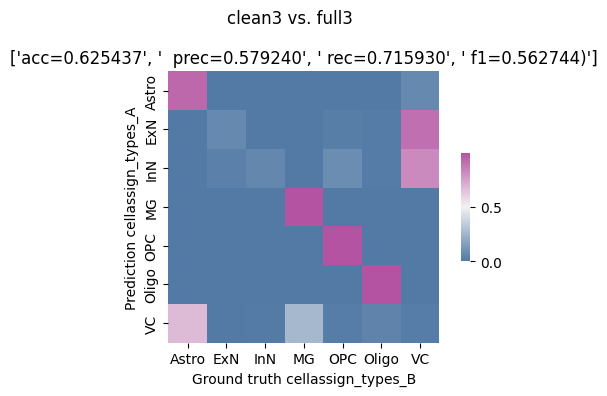

In [8]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 3

for noise in ["_noise", ""]:
    samp_set = "clean"
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    samp_set = "full"
    B = f"{samp_set}{rep}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )
    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")



#### implications

_Without_ the `noise` batch correction the full dataset (presumably driven by the "dirty" samples) classify many of the neurons as "fibrous_astrocytes" and there is very poor correspondence between the "clean" samples when fit _with_ the "dirty" samples versus alone.  However _with_ batch correction including continuous `noise` covariates (`["doublet_score", "pct_counts_mt", "pct_counts_rb"]` ) the cell type assignments are overal quite accurate between the two datasets.   The notable exception are the "unknown", "t_cell" and "b_cell" assigned cells.  However these represent extremely rare cell types according to this dataset and assignment.

## conclusions

For "ground truth" assignments fitting cellassign with the continusous `noise` covariates on the "full" dataset should give us the most reasonable ground truth. 

Next steps:
- consider further simplified 
- consider alternate ground truth assignment methods which might leverage additional priors.  Here we are only constrained by consistency and the assumed marker genes
- estimate baseline performance of this ground truth designation procedure by analyzing the stability of assignments with different seed values. 

## repeatability...

 N samples full3_noise= 2012744, N samples full4_noise= 2012744
                  full3_noisepct  full4_noisepct  full3_noise  full4_noise
cellassign_types                                                          
Oligo                  36.530925       36.530925       735274       735274
ExN                    30.609407       30.609407       616089       616089
InN                    14.732773       14.732773       296533       296533
Astro                   8.340306        8.340306       167869       167869
OPC                     5.479336        5.479336       110285       110285
MG                      4.037374        4.037374        81262        81262
VC                      0.269880        0.269880         5432         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 1000247, N samples clean4_noise= 1000247
                  clean3_noisepct  clean4_noisepct  clean3_noise  clean4_noise
cellassign_types                                                              
Oligo                   43.796182        43.796182        438070        438070
InN                     39.173924        39.173924        391836        391836
Astro                    6.914592         6.914592         69163         69163
OPC                      5.270098         5.270098         52714         52714
MG                       4.645752         4.645752         46469         46469
VC                       0.182955         0.182955          1830          1830
ExN                      0.016496         0.016496           165           165


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3= 1000247, N samples clean4= 1000247
                  clean3pct  clean4pct  clean3  clean4
cellassign_types                                      
Oligo             44.004131  44.004131  440150  440150
InN               28.802086  28.802086  288092  288092
ExN                9.911452   9.911452   99139   99139
Astro              7.038262   7.038262   70400   70400
OPC                5.275197   5.275197   52765   52765
MG                 4.663348   4.663348   46645   46645
VC                 0.305525   0.305525    3056    3056


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


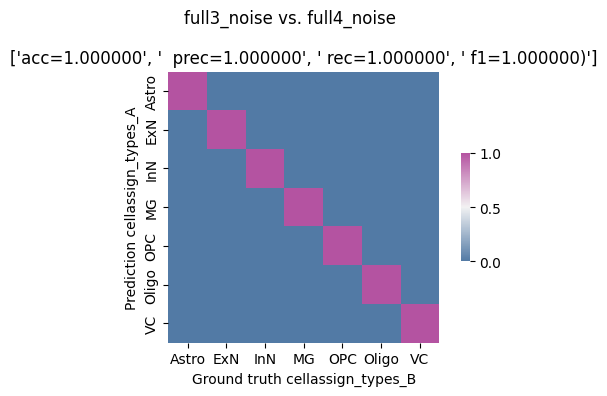

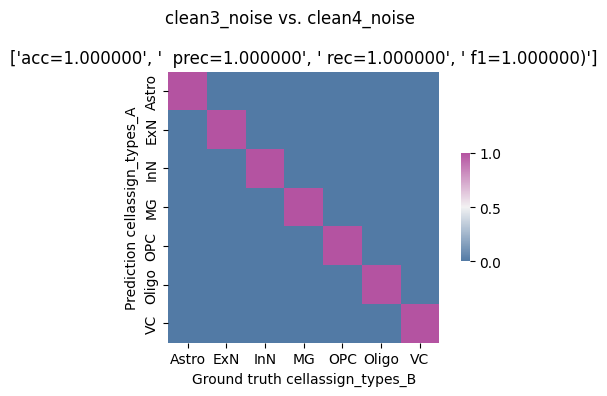

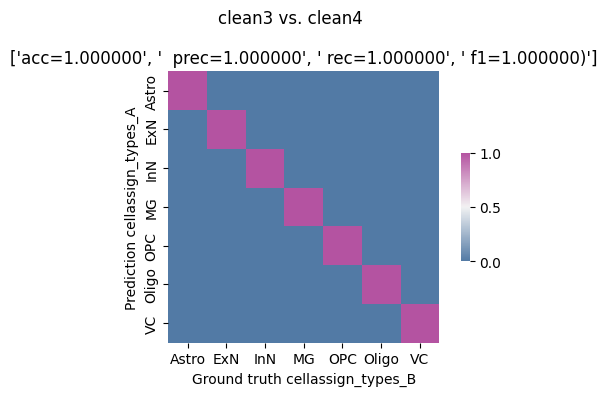

In [9]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 3
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 4
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

### results

Seems to be some great confusion between immune cells:  microglia, t_cell, b_cell, for the clean dataset without the noise parameters.



 N samples full3_noise= 2012744, N samples full4_noise= 2012744
                  full3_noisepct  full4_noisepct  full3_noise  full4_noise
cellassign_types                                                          
Oligo                  36.530925       36.530925       735274       735274
ExN                    30.609407       30.609407       616089       616089
InN                    14.732773       14.732773       296533       296533
Astro                   8.340306        8.340306       167869       167869
OPC                     5.479336        5.479336       110285       110285
MG                      4.037374        4.037374        81262        81262
VC                      0.269880        0.269880         5432         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 1000247, N samples clean4_noise= 1000247
                  clean3_noisepct  clean4_noisepct  clean3_noise  clean4_noise
cellassign_types                                                              
Oligo                   43.796182        43.796182        438070        438070
InN                     39.173924        39.173924        391836        391836
Astro                    6.914592         6.914592         69163         69163
OPC                      5.270098         5.270098         52714         52714
MG                       4.645752         4.645752         46469         46469
VC                       0.182955         0.182955          1830          1830
ExN                      0.016496         0.016496           165           165


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3= 1000247, N samples clean4= 1000247
                  clean3pct  clean4pct  clean3  clean4
cellassign_types                                      
Oligo             44.004131  44.004131  440150  440150
InN               28.802086  28.802086  288092  288092
ExN                9.911452   9.911452   99139   99139
Astro              7.038262   7.038262   70400   70400
OPC                5.275197   5.275197   52765   52765
MG                 4.663348   4.663348   46645   46645
VC                 0.305525   0.305525    3056    3056


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


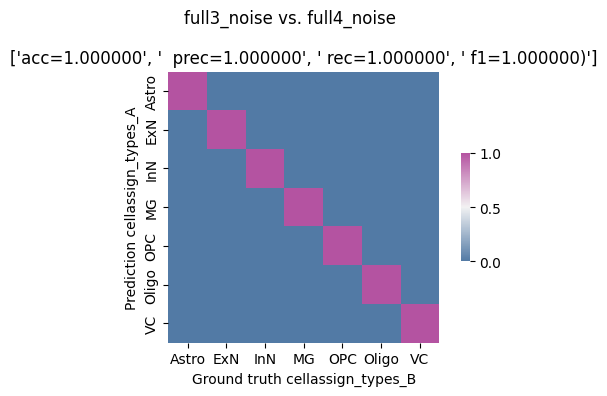

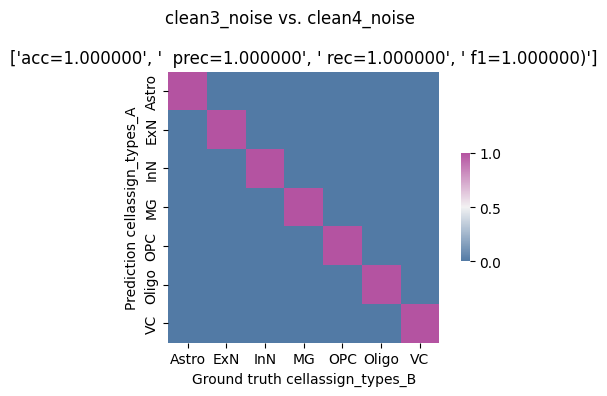

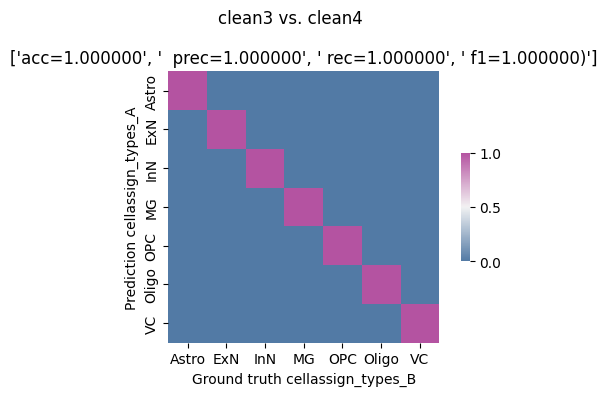

In [10]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 3
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 4
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

 N samples full0_noise= 2012744, N samples full1_noise= 2012744
                  full0_noisepct  full1_noisepct  full0_noise  full1_noise
cellassign_types                                                          
Oligo                  36.602519       36.492917       736715       734509
InN                    26.312487        7.889031       529603       158786
ExN                    18.762098       37.448776       377633       753748
Astro                   8.362713        8.277754       168320       166610
OPC                     5.558034        5.572989       111869       112170
MG                      4.040802        4.048056        81331        81477
VC                      0.361347        0.270477         7273         5444


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full0_noise= 2012744, N samples full2_noise= 2012744
                  full0_noisepct  full2_noisepct  full0_noise  full2_noise
cellassign_types                                                          
Oligo                  36.602519       36.530925       736715       735274
InN                    26.312487       14.732773       529603       296533
ExN                    18.762098       30.609407       377633       616089
Astro                   8.362713        8.340306       168320       167869
OPC                     5.558034        5.479336       111869       110285
MG                      4.040802        4.037374        81331        81262
VC                      0.361347        0.269880         7273         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full0_noise= 2012744, N samples full3_noise= 2012744
                  full0_noisepct  full3_noisepct  full0_noise  full3_noise
cellassign_types                                                          
Oligo                  36.602519       36.530925       736715       735274
InN                    26.312487       14.732773       529603       296533
ExN                    18.762098       30.609407       377633       616089
Astro                   8.362713        8.340306       168320       167869
OPC                     5.558034        5.479336       111869       110285
MG                      4.040802        4.037374        81331        81262
VC                      0.361347        0.269880         7273         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full0_noise= 2012744
                  full1_noisepct  full0_noisepct  full1_noise  full0_noise
cellassign_types                                                          
ExN                    37.448776       18.762098       753748       377633
Oligo                  36.492917       36.602519       734509       736715
Astro                   8.277754        8.362713       166610       168320
InN                     7.889031       26.312487       158786       529603
OPC                     5.572989        5.558034       112170       111869
MG                      4.048056        4.040802        81477        81331
VC                      0.270477        0.361347         5444         7273


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full2_noise= 2012744
                  full1_noisepct  full2_noisepct  full1_noise  full2_noise
cellassign_types                                                          
ExN                    37.448776       30.609407       753748       616089
Oligo                  36.492917       36.530925       734509       735274
Astro                   8.277754        8.340306       166610       167869
InN                     7.889031       14.732773       158786       296533
OPC                     5.572989        5.479336       112170       110285
MG                      4.048056        4.037374        81477        81262
VC                      0.270477        0.269880         5444         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full3_noise= 2012744
                  full1_noisepct  full3_noisepct  full1_noise  full3_noise
cellassign_types                                                          
ExN                    37.448776       30.609407       753748       616089
Oligo                  36.492917       36.530925       734509       735274
Astro                   8.277754        8.340306       166610       167869
InN                     7.889031       14.732773       158786       296533
OPC                     5.572989        5.479336       112170       110285
MG                      4.048056        4.037374        81477        81262
VC                      0.270477        0.269880         5444         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full0_noise= 2012744
                  full2_noisepct  full0_noisepct  full2_noise  full0_noise
cellassign_types                                                          
Oligo                  36.530925       36.602519       735274       736715
ExN                    30.609407       18.762098       616089       377633
InN                    14.732773       26.312487       296533       529603
Astro                   8.340306        8.362713       167869       168320
OPC                     5.479336        5.558034       110285       111869
MG                      4.037374        4.040802        81262        81331
VC                      0.269880        0.361347         5432         7273


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full1_noise= 2012744
                  full2_noisepct  full1_noisepct  full2_noise  full1_noise
cellassign_types                                                          
Oligo                  36.530925       36.492917       735274       734509
ExN                    30.609407       37.448776       616089       753748
InN                    14.732773        7.889031       296533       158786
Astro                   8.340306        8.277754       167869       166610
OPC                     5.479336        5.572989       110285       112170
MG                      4.037374        4.048056        81262        81477
VC                      0.269880        0.270477         5432         5444


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full3_noise= 2012744
                  full2_noisepct  full3_noisepct  full2_noise  full3_noise
cellassign_types                                                          
Oligo                  36.530925       36.530925       735274       735274
ExN                    30.609407       30.609407       616089       616089
InN                    14.732773       14.732773       296533       296533
Astro                   8.340306        8.340306       167869       167869
OPC                     5.479336        5.479336       110285       110285
MG                      4.037374        4.037374        81262        81262
VC                      0.269880        0.269880         5432         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full0_noise= 2012744
                  full3_noisepct  full0_noisepct  full3_noise  full0_noise
cellassign_types                                                          
Oligo                  36.530925       36.602519       735274       736715
ExN                    30.609407       18.762098       616089       377633
InN                    14.732773       26.312487       296533       529603
Astro                   8.340306        8.362713       167869       168320
OPC                     5.479336        5.558034       110285       111869
MG                      4.037374        4.040802        81262        81331
VC                      0.269880        0.361347         5432         7273


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full1_noise= 2012744
                  full3_noisepct  full1_noisepct  full3_noise  full1_noise
cellassign_types                                                          
Oligo                  36.530925       36.492917       735274       734509
ExN                    30.609407       37.448776       616089       753748
InN                    14.732773        7.889031       296533       158786
Astro                   8.340306        8.277754       167869       166610
OPC                     5.479336        5.572989       110285       112170
MG                      4.037374        4.048056        81262        81477
VC                      0.269880        0.270477         5432         5444


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full2_noise= 2012744
                  full3_noisepct  full2_noisepct  full3_noise  full2_noise
cellassign_types                                                          
Oligo                  36.530925       36.530925       735274       735274
ExN                    30.609407       30.609407       616089       616089
InN                    14.732773       14.732773       296533       296533
Astro                   8.340306        8.340306       167869       167869
OPC                     5.479336        5.479336       110285       110285
MG                      4.037374        4.037374        81262        81262
VC                      0.269880        0.269880         5432         5432


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


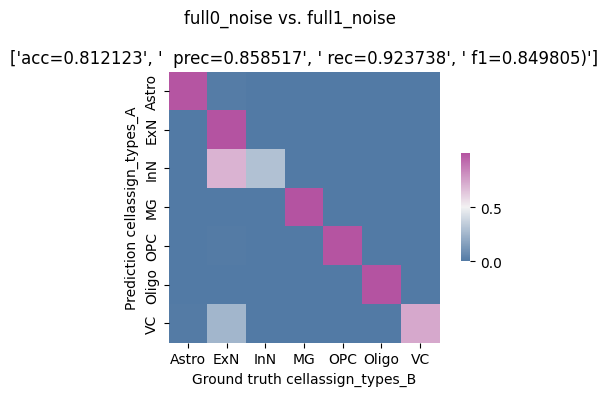

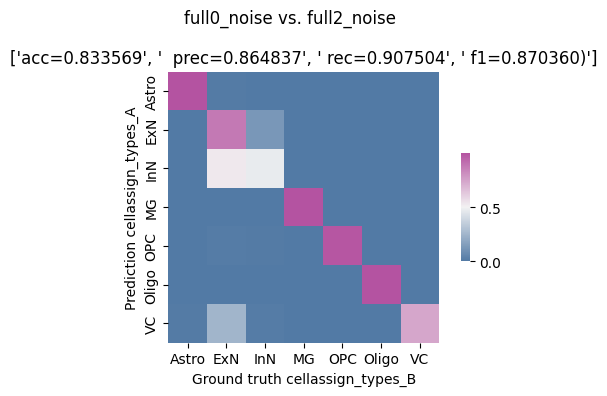

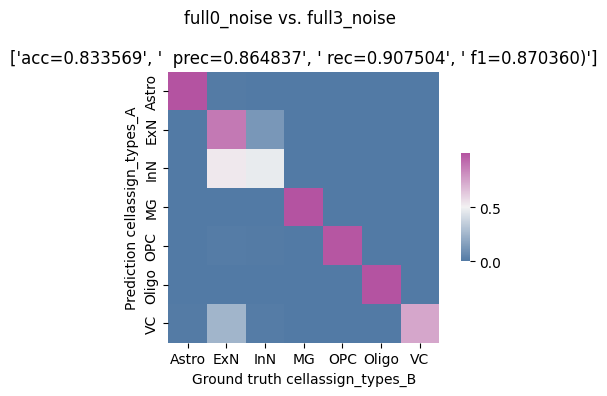

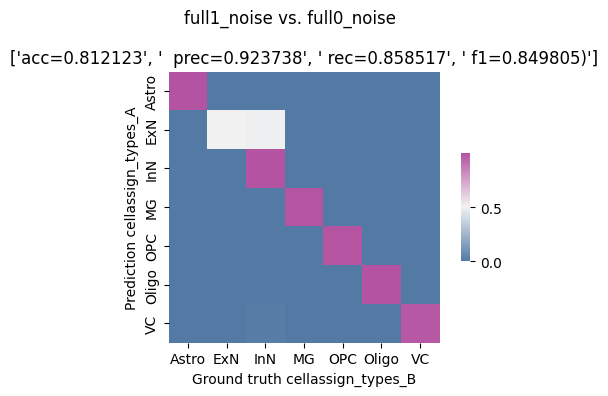

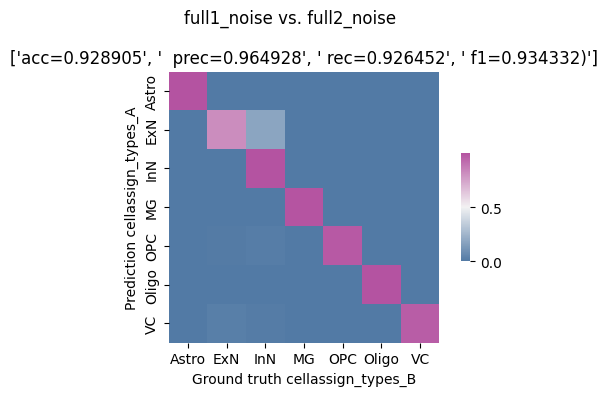

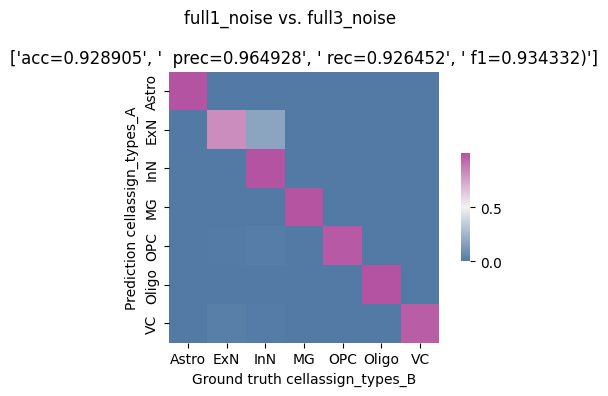

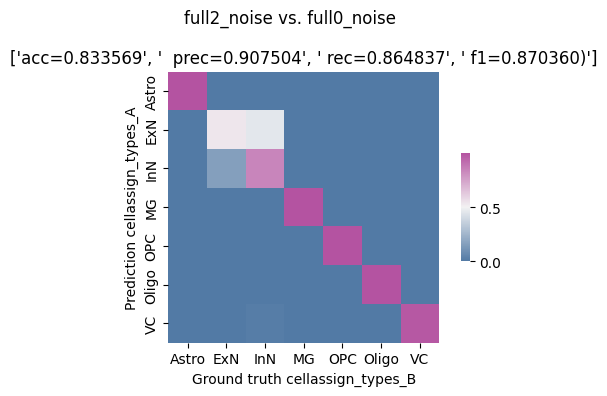

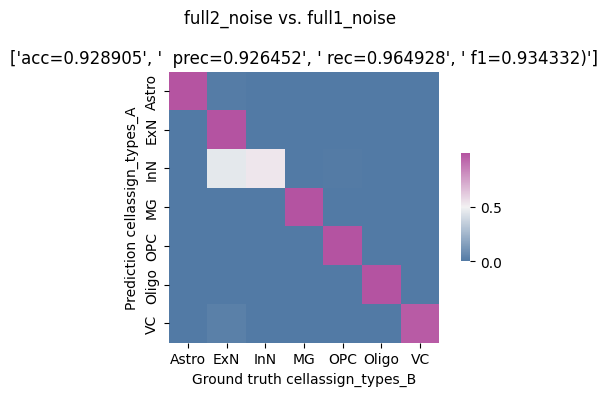

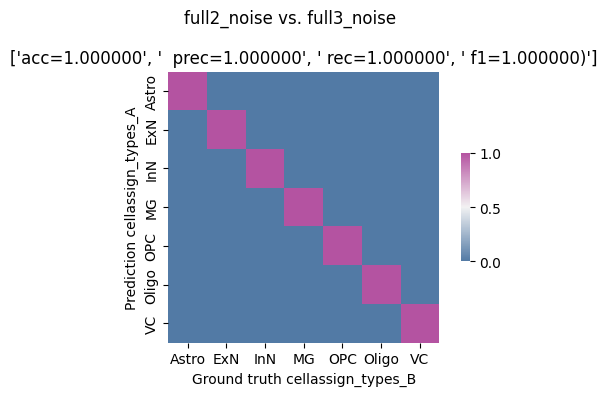

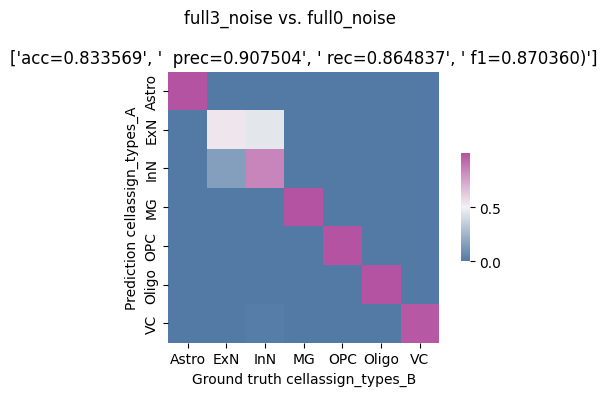

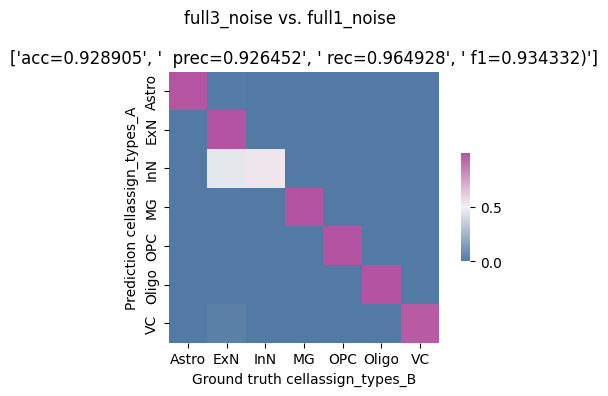

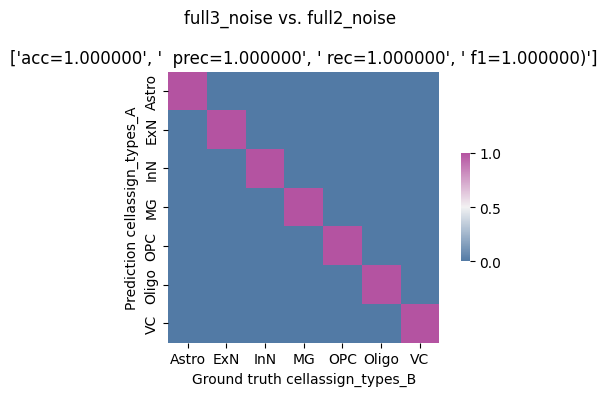

In [11]:
samp_set = "full"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [12]:
samp_set = "full"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

counts 0-3
                  full0_noise  full1_noise  full2_noise  full3_noise
cellassign_types                                                    
Oligo                  736715       734509       735274       735274
InN                    529603       158786       296533       296533
ExN                    377633       753748       616089       616089
Astro                  168320       166610       167869       167869
OPC                    111869       112170       110285       110285
MG                      81331        81477        81262        81262
VC                       7273         5444         5432         5432
pcts 0-3
                  full0_noise  full1_noise  full2_noise  full3_noise
cellassign_types                                                    
Oligo               36.602519    36.492917    36.530925    36.530925
InN                 26.312487     7.889031    14.732773    14.732773
ExN                 18.762098    37.448776    30.609407    30.609407
Astro         

 N samples clean0_noise= 1000247, N samples clean1_noise= 1000247
                  clean0_noisepct  clean1_noisepct  clean0_noise  clean1_noise
cellassign_types                                                              
Oligo                   43.927950        43.847070        439388        438579
InN                     23.608269        11.807384        236141        118103
ExN                     15.184749        27.131598        151885        271383
Astro                    6.982775         6.972978         69845         69747
OPC                      5.335882         5.335182         53372         53365
MG                       4.652651         4.657550         46538         46587
VC                       0.307724         0.248239          3078          2483


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 1000247, N samples clean2_noise= 1000247
                  clean0_noisepct  clean2_noisepct  clean0_noise  clean2_noise
cellassign_types                                                              
Oligo                   43.927950        43.796182        439388        438070
InN                     23.608269        39.173924        236141        391836
ExN                     15.184749         0.016496        151885           165
Astro                    6.982775         6.914592         69845         69163
OPC                      5.335882         5.270098         53372         52714
MG                       4.652651         4.645752         46538         46469
VC                       0.307724         0.182955          3078          1830


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 1000247, N samples clean3_noise= 1000247
                  clean0_noisepct  clean3_noisepct  clean0_noise  clean3_noise
cellassign_types                                                              
Oligo                   43.927950        43.796182        439388        438070
InN                     23.608269        39.173924        236141        391836
ExN                     15.184749         0.016496        151885           165
Astro                    6.982775         6.914592         69845         69163
OPC                      5.335882         5.270098         53372         52714
MG                       4.652651         4.645752         46538         46469
VC                       0.307724         0.182955          3078          1830


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 1000247, N samples clean0_noise= 1000247
                  clean1_noisepct  clean0_noisepct  clean1_noise  clean0_noise
cellassign_types                                                              
Oligo                   43.847070        43.927950        438579        439388
ExN                     27.131598        15.184749        271383        151885
InN                     11.807384        23.608269        118103        236141
Astro                    6.972978         6.982775         69747         69845
OPC                      5.335182         5.335882         53365         53372
MG                       4.657550         4.652651         46587         46538
VC                       0.248239         0.307724          2483          3078


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 1000247, N samples clean2_noise= 1000247
                  clean1_noisepct  clean2_noisepct  clean1_noise  clean2_noise
cellassign_types                                                              
Oligo                   43.847070        43.796182        438579        438070
ExN                     27.131598         0.016496        271383           165
InN                     11.807384        39.173924        118103        391836
Astro                    6.972978         6.914592         69747         69163
OPC                      5.335182         5.270098         53365         52714
MG                       4.657550         4.645752         46587         46469
VC                       0.248239         0.182955          2483          1830


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 1000247, N samples clean3_noise= 1000247
                  clean1_noisepct  clean3_noisepct  clean1_noise  clean3_noise
cellassign_types                                                              
Oligo                   43.847070        43.796182        438579        438070
ExN                     27.131598         0.016496        271383           165
InN                     11.807384        39.173924        118103        391836
Astro                    6.972978         6.914592         69747         69163
OPC                      5.335182         5.270098         53365         52714
MG                       4.657550         4.645752         46587         46469
VC                       0.248239         0.182955          2483          1830


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean2_noise= 1000247, N samples clean0_noise= 1000247
                  clean2_noisepct  clean0_noisepct  clean2_noise  clean0_noise
cellassign_types                                                              
Oligo                   43.796182        43.927950        438070        439388
InN                     39.173924        23.608269        391836        236141
Astro                    6.914592         6.982775         69163         69845
OPC                      5.270098         5.335882         52714         53372
MG                       4.645752         4.652651         46469         46538
VC                       0.182955         0.307724          1830          3078
ExN                      0.016496        15.184749           165        151885


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean2_noise= 1000247, N samples clean1_noise= 1000247
                  clean2_noisepct  clean1_noisepct  clean2_noise  clean1_noise
cellassign_types                                                              
Oligo                   43.796182        43.847070        438070        438579
InN                     39.173924        11.807384        391836        118103
Astro                    6.914592         6.972978         69163         69747
OPC                      5.270098         5.335182         52714         53365
MG                       4.645752         4.657550         46469         46587
VC                       0.182955         0.248239          1830          2483
ExN                      0.016496        27.131598           165        271383


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean2_noise= 1000247, N samples clean3_noise= 1000247
                  clean2_noisepct  clean3_noisepct  clean2_noise  clean3_noise
cellassign_types                                                              
Oligo                   43.796182        43.796182        438070        438070
InN                     39.173924        39.173924        391836        391836
Astro                    6.914592         6.914592         69163         69163
OPC                      5.270098         5.270098         52714         52714
MG                       4.645752         4.645752         46469         46469
VC                       0.182955         0.182955          1830          1830
ExN                      0.016496         0.016496           165           165


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 1000247, N samples clean0_noise= 1000247
                  clean3_noisepct  clean0_noisepct  clean3_noise  clean0_noise
cellassign_types                                                              
Oligo                   43.796182        43.927950        438070        439388
InN                     39.173924        23.608269        391836        236141
Astro                    6.914592         6.982775         69163         69845
OPC                      5.270098         5.335882         52714         53372
MG                       4.645752         4.652651         46469         46538
VC                       0.182955         0.307724          1830          3078
ExN                      0.016496        15.184749           165        151885


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 1000247, N samples clean1_noise= 1000247
                  clean3_noisepct  clean1_noisepct  clean3_noise  clean1_noise
cellassign_types                                                              
Oligo                   43.796182        43.847070        438070        438579
InN                     39.173924        11.807384        391836        118103
Astro                    6.914592         6.972978         69163         69747
OPC                      5.270098         5.335182         52714         53365
MG                       4.645752         4.657550         46469         46587
VC                       0.182955         0.248239          1830          2483
ExN                      0.016496        27.131598           165        271383


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean3_noise= 1000247, N samples clean2_noise= 1000247
                  clean3_noisepct  clean2_noisepct  clean3_noise  clean2_noise
cellassign_types                                                              
Oligo                   43.796182        43.796182        438070        438070
InN                     39.173924        39.173924        391836        391836
Astro                    6.914592         6.914592         69163         69163
OPC                      5.270098         5.270098         52714         52714
MG                       4.645752         4.645752         46469         46469
VC                       0.182955         0.182955          1830          1830
ExN                      0.016496         0.016496           165           165


/var/tmp/ipykernel_51566/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


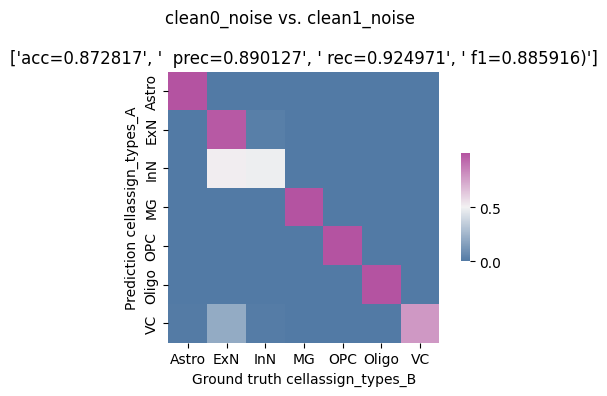

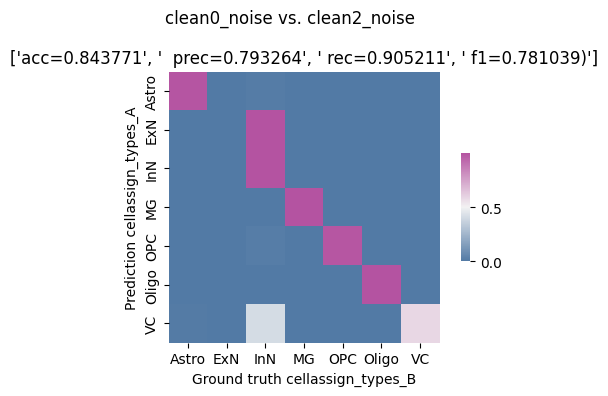

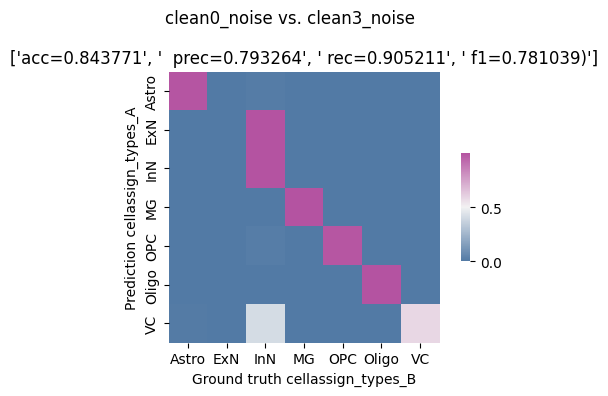

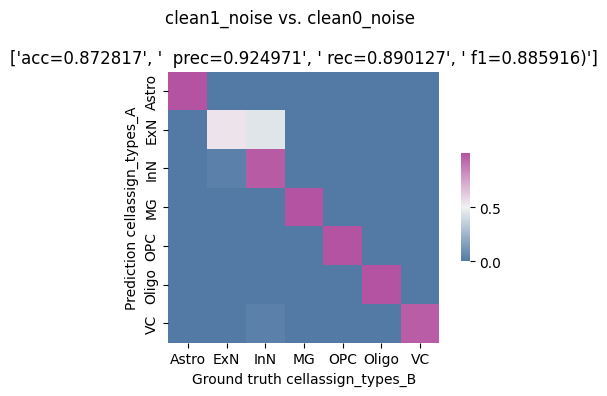

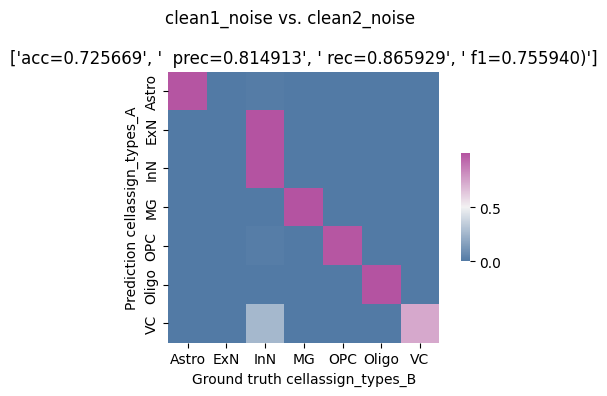

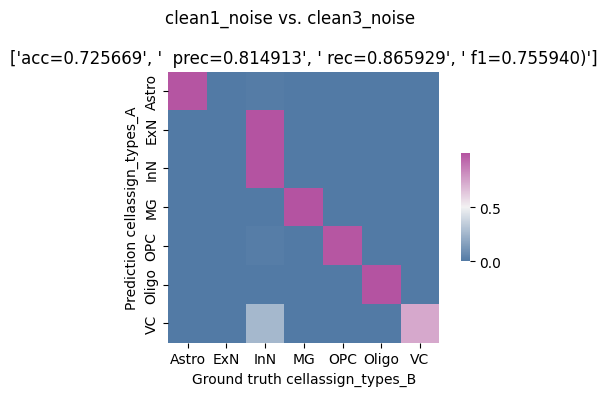

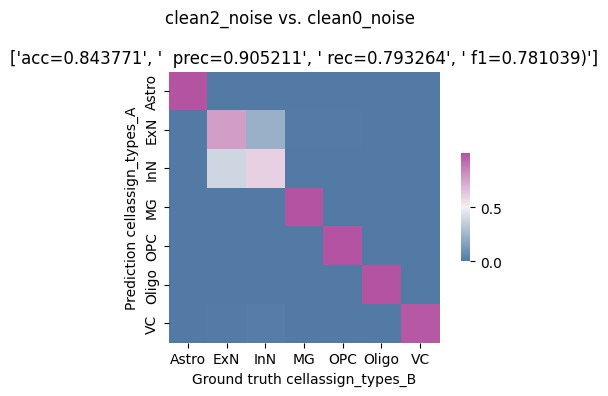

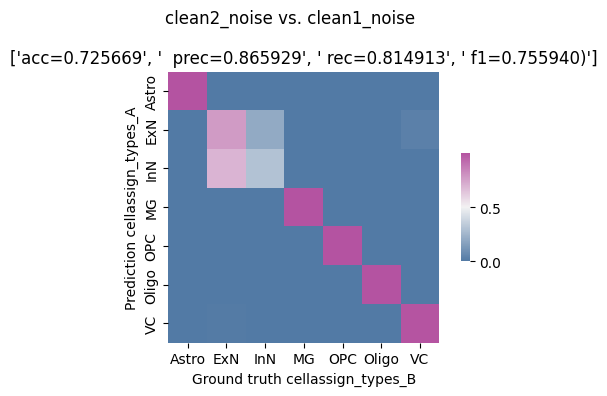

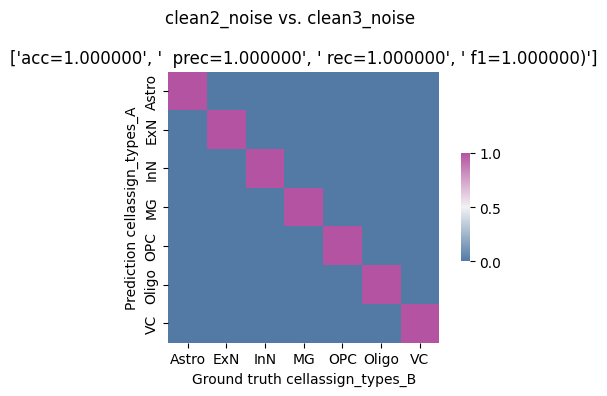

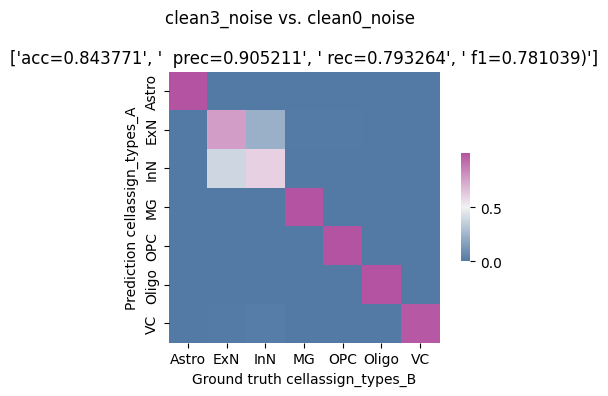

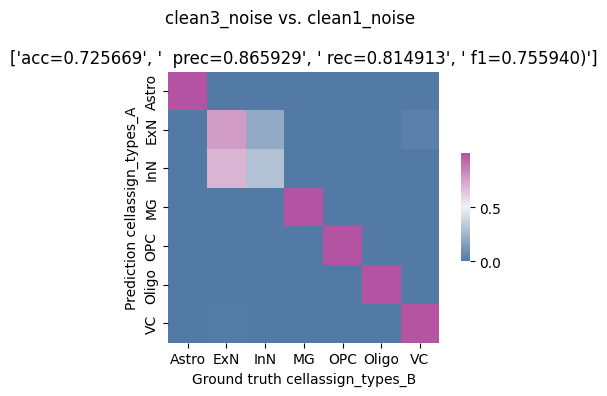

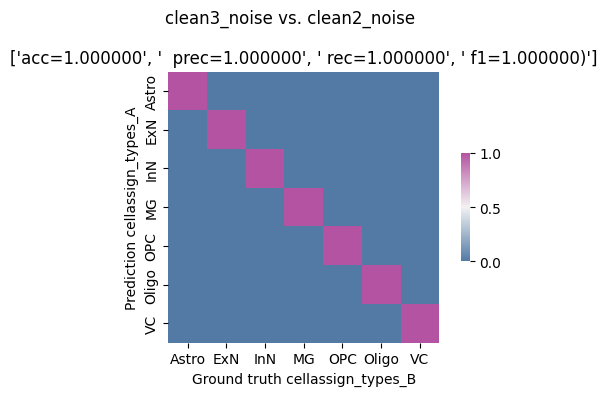

In [13]:
samp_set = "clean"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [14]:
samp_set = "clean"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

counts 0-3
                  clean0_noise  clean1_noise  clean2_noise  clean3_noise
cellassign_types                                                        
Oligo                   439388        438579        438070        438070
InN                     236141        118103        391836        391836
ExN                     151885        271383           165           165
Astro                    69845         69747         69163         69163
OPC                      53372         53365         52714         52714
MG                       46538         46587         46469         46469
VC                        3078          2483          1830          1830
pcts 0-3
                  clean0_noise  clean1_noise  clean2_noise  clean3_noise
cellassign_types                                                        
Oligo                43.927950     43.847070     43.796182     43.796182
InN                  23.608269     11.807384     39.173924     39.173924
ExN                  15.184749 

In [16]:
predictionsA

,Oligo,OPC,ExN,InN,Astro,MG,VC,cellassign_types,cell_type,sample,cell
0,1.331456e-62,3.043054e-46,1.269505e-16,1.000000e+00,1.015866e-46,1.376136e-22,5.828606e-27,InN,UNKNOWN,1221-ARC,ATCACCCTCTAATCTC-1_1221-ARC
1,3.211432e-60,8.061969e-36,1.659523e-02,9.834048e-01,8.431362e-37,1.229285e-13,1.150615e-16,InN,UNKNOWN,1221-ARC,CATAATCCAATTATGC-1_1221-ARC
2,2.394604e-72,3.613709e-59,7.838768e-06,9.999922e-01,1.668559e-56,1.337359e-31,1.790472e-34,InN,UNKNOWN,1221-ARC,AGTAATGCAAACCTTG-1_1221-ARC
3,5.842563e-53,1.669081e-29,3.869369e-05,9.999613e-01,2.520574e-45,4.211210e-11,1.455633e-13,InN,ExN,1221-ARC,ATGACAACAGTTTCTC-1_1221-ARC
4,1.097916e-68,2.826951e-36,6.856342e-03,9.931437e-01,1.715882e-41,1.888515e-20,5.705658e-23,InN,UNKNOWN,1221-ARC,ACCAATATCATTACAG-1_1221-ARC
...,...,...,...,...,...,...,...,...,...,...,...
1000242,1.756891e-15,1.000000e+00,3.019100e-19,1.101281e-14,1.581598e-15,1.084081e-15,2.880840e-17,OPC,UNKNOWN,UMARY-933-ARC,ACAACAGAGTCACCTC-1_UMARY-933-ARC
1000243,3.551789e-02,2.610879e-02,2.269930e-06,8.124566e-01,6.569701e-02,5.888838e-02,1.329108e-03,InN,UNKNOWN,UMARY-933-ARC,CTACTAAAGCTAATTG-1_UMARY-933-ARC
1000244,6.970808e-04,2.517115e-04,7.590251e-07,9.977128e-01,7.566392e-04,5.645964e-04,1.646291e-05,InN,UNKNOWN,UMARY-933-ARC,CATTGTAAGCAACAAG-1_UMARY-933-ARC
1000245,6.473131e-02,1.629723e-02,1.066476e-36,8.820977e-01,2.312500e-02,1.296725e-02,7.815410e-04,InN,UNKNOWN,UMARY-933-ARC,GCTAAGAAGTTATTCC-1_UMARY-933-ARC


In [14]:
preds

NameError: name 'preds' is not defined

In [15]:
predictions

,oligo,opc,glutamatergic,gabergic,protoplasmic_astrocyte,fibrous_astrocyte,microglia,t_cell,b_cell,pericyte,endothelial,unknown,cellassign_types,cell_type,sample,cell
AGCTTAATCCTTAAGA-1_1134-ARC,8.070967e-19,2.066018e-07,6.553242e-14,3.515823e-15,1.660158e-11,9.999924e-01,5.075886e-06,1.170981e-17,2.266605e-06,1.079137e-17,1.577539e-20,2.580642e-09,fibrous_astrocyte,glutamatergic,1134-ARC,AGCTTAATCCTTAAGA-1_1134-ARC
TATATCCTCTTGATGA-1_1134-ARC,6.801635e-23,8.827080e-08,8.033812e-09,1.859673e-12,4.399218e-11,9.997374e-01,2.359720e-04,7.018505e-15,2.650754e-05,4.066693e-18,8.359755e-16,3.124652e-08,fibrous_astrocyte,glutamatergic,1134-ARC,TATATCCTCTTGATGA-1_1134-ARC
ACACAATGTACTAAAC-1_1134-ARC,8.071695e-26,1.124705e-09,2.038490e-09,2.960360e-13,6.147943e-08,9.999971e-01,1.045800e-06,1.447950e-24,1.758187e-06,4.517531e-20,3.295211e-17,2.097122e-09,fibrous_astrocyte,glutamatergic,1134-ARC,ACACAATGTACTAAAC-1_1134-ARC
CTAGATTCATGTCAGC-1_1134-ARC,3.632498e-24,1.119848e-06,4.563372e-06,1.232154e-10,1.248253e-10,9.978832e-01,4.800004e-04,3.658783e-12,1.629206e-03,2.308527e-16,1.558395e-12,1.956315e-06,fibrous_astrocyte,glutamatergic,1134-ARC,CTAGATTCATGTCAGC-1_1134-ARC
AATGTCATCATAATCG-1_1134-ARC,4.018614e-25,4.830847e-10,4.800599e-07,3.304295e-13,3.234424e-08,9.999829e-01,1.639706e-06,4.083418e-14,1.493679e-05,9.614743e-20,7.887875e-16,1.796647e-08,fibrous_astrocyte,glutamatergic,1134-ARC,AATGTCATCATAATCG-1_1134-ARC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAACAGAGTCACCTC-1_UMARY-933-ARC,2.656263e-17,1.000000e+00,1.607677e-17,1.350737e-17,4.094026e-17,3.722711e-16,2.597679e-17,5.181004e-24,8.750678e-22,1.476936e-18,2.228320e-18,4.607009e-22,opc,opc,UMARY-933-ARC,ACAACAGAGTCACCTC-1_UMARY-933-ARC
CTACTAAAGCTAATTG-1_UMARY-933-ARC,5.443109e-02,3.364262e-02,3.140698e-02,2.614744e-02,8.021798e-02,7.159961e-01,5.077026e-02,3.229378e-09,1.910092e-06,2.905543e-03,4.479178e-03,8.858699e-07,fibrous_astrocyte,glutamatergic,UMARY-933-ARC,CTACTAAAGCTAATTG-1_UMARY-933-ARC
CATTGTAAGCAACAAG-1_UMARY-933-ARC,2.631828e-02,1.682088e-02,4.117222e-01,9.748156e-02,4.116664e-02,3.766419e-01,2.614240e-02,7.502265e-09,8.488473e-07,1.483117e-03,2.221772e-03,4.661459e-07,glutamatergic,glutamatergic,UMARY-933-ARC,CATTGTAAGCAACAAG-1_UMARY-933-ARC
GCTAAGAAGTTATTCC-1_UMARY-933-ARC,5.277312e-02,3.307912e-02,3.127264e-02,2.616840e-02,7.974229e-02,7.191500e-01,5.054014e-02,6.118936e-09,1.788162e-06,2.881873e-03,4.389688e-03,8.898865e-07,fibrous_astrocyte,glutamatergic,UMARY-933-ARC,GCTAAGAAGTTATTCC-1_UMARY-933-ARC


In [ ]:
def get_stats_from_probs(predictions: pd.DataFrame, cell_types: list) -> pd.DataFrame:
    """
    Get probabilities, entropy, log entropy, labels, and margin of probability.
    """
    # Applying softmax to convert logits to probabilities
    probabilities = predictions[cell_types].values

    # Calculate entropy
    entropy = -np.sum(probabilities * np.log(probabilities), axis=1)

    # n_classes = probabilities.shape[1]
    logents = entropy.log().numpy()

    # print("Logits: ", logs)
    # print("Probabilities: ", probs)

    maxprobs = probabilities.max(axis=1)

    # Binarize the true labels for each class
    from sklearn.preprocessing import label_binarize

    labels = label_binarize(y_true, classes=np.arange(len(cell_types)))

    labels = categories[probabilities.argmax(axis=1)]

    margin = calculate_margin_of_probability(probabilities)

    return {
        "logit": logs,
        "prob": probs,
        "entropy": ents,
        "logE": logents,
        "max_p": maxprobs,
        "mop": margin,
        "label": labels,
    }


def calculate_margin_of_probability(probabilities: torch.Tensor) -> np.ndarray:
    """
    Calculate the margin of probability.

    Parameters
    ----------
    probabilities : torch.Tensor
        Probabilities from a model.

    Returns
    -------
    np.ndarray
        Array of margin of probability.
    """
    # Get the top two probabilities
    top_probs, _ = torch.topk(probabilities, 2)

    # Calculate the margin
    margin = top_probs[:, 0] - top_probs[:, 1]
    return margin.numpy()

In [17]:
ground_truth = pd.read_csv(
    Path.cwd().parent / "data/scdata/xylena_raw/cell_barcode_labels.csv", index_col=0
)

In [18]:
ground_truth.head()

,seurat_clusters,cell_type,sample
cells,,,
GGCCTAATCGATTTAG-1_1,11,Mature neurons,KEN-1070-ARC
TAGTAACGTAGTCAAT-1_1,5,Mature neurons,KEN-1070-ARC
GAAAGCCAGCAGCTCA-1_1,2,Oligodendrocytes,KEN-1070-ARC
ACTCACCTCCTCCCTC-1_1,5,Mature neurons,KEN-1070-ARC
CTTCATCCAATCGCAC-1_1,11,Mature neurons,KEN-1070-ARC


In [19]:
ground_truth.shape

(713626, 3)

In [21]:
ground_truth.cell_type.value_counts()

cell_type
Oligodendrocytes                   287587
Mature neurons                      99925
Glutamatergic neurons               84684
GABAergic neurons                   81731
Astrocytes                          54362
Oligodendrocyte precursor cells     41993
Microglial cells                    40227
Radial glial cells                  15998
Endothelial cells                    7119
Name: count, dtype: int64

In [22]:
100 * ground_truth.cell_type.value_counts() / ground_truth.shape[0]

cell_type
Oligodendrocytes                   40.299401
Mature neurons                     14.002433
Glutamatergic neurons              11.866720
GABAergic neurons                  11.452918
Astrocytes                          7.617716
Oligodendrocyte precursor cells     5.884455
Microglial cells                    5.636986
Radial glial cells                  2.241791
Endothelial cells                   0.997581
Name: count, dtype: float64

In [23]:
ground_truth.sample.value_counts()

AttributeError: 'function' object has no attribute 'value_counts'

In [25]:
ground_truth["sample"].value_counts()

sample
KEN-1159-ARC      11317
UMARY-5088-ARC    11247
UMARY-871-ARC     11118
KEN-1066-ARC      10280
SH-92-05-ARC       9325
                  ...  
UMARY-1465-ARC     1173
UMARY-4263-ARC     1103
UMARY-5028-ARC      818
UMARY-4842-ARC      368
UMARY-1789-ARC      255
Name: count, Length: 138, dtype: int64

In [27]:
adata.obs._cell_type.value_counts()

_cell_type
NONE    2012744
Name: count, dtype: int64

PosixPath('/home/ergonyc/Projects/SingleCell/labelator/data/scdata/xylena_raw')

In [35]:
filen = Path.cwd().parent / "data/scdata/xylena_raw/brain_atlas_anndata.h5ad"
adata = ad.read_h5ad(filen)

In [36]:
adata

AnnData object with n_obs × n_vars = 709811 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample'

In [37]:
adata.obs.cell_type.value_counts()

cell_type
Oligo    321846
ExN      161024
InN       78813
Astro     61165
OPC       41691
MG        37581
VC         7678
Name: count, dtype: int64

In [38]:
filen = Path.cwd().parent / "data/scdata/xylena_raw/brain_atlas_anndata.h5ad"
adata = ad.read_h5ad(filen)

In [39]:
adata

AnnData object with n_obs × n_vars = 709811 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample'

In [40]:
adata.obs.cell_type.value_counts()

cell_type
Oligo    321846
ExN      161024
InN       78813
Astro     61165
OPC       41691
MG        37581
VC         7678
Name: count, dtype: int64

In [41]:
100 * adata.obs.cell_type.value_counts() / adata.shape[0]

cell_type
Oligo    45.342493
ExN      22.685475
InN      11.103378
Astro     8.617083
OPC       5.873535
MG        5.294508
VC        1.081696
Name: count, dtype: float64

In [42]:
adata.head()

AttributeError: 'AnnData' object has no attribute 'head'

In [43]:
adata.obs.head()

,seurat_clusters,cell_type,sample
cells,,,
GGCCTAATCGATTTAG-1_1,8,ExN,KEN-1070-ARC
TAGTAACGTAGTCAAT-1_1,2,ExN,KEN-1070-ARC
GAAAGCCAGCAGCTCA-1_1,2,ExN,KEN-1070-ARC
ACTCACCTCCTCCCTC-1_1,2,ExN,KEN-1070-ARC
CTTCATCCAATCGCAC-1_1,8,ExN,KEN-1070-ARC


In [46]:
adata.obs["sample"].value_counts()

sample
KEN-1159-ARC      11317
UMARY-5088-ARC    11247
KEN-1066-ARC      10280
SH-92-05-ARC       9325
SH-03-15-ARC       9055
                  ...  
UMARY-4727-ARC     1554
UMARY-1465-ARC     1173
UMARY-4263-ARC     1103
UMARY-5028-ARC      828
UMARY-1789-ARC      255
Name: count, Length: 138, dtype: int64

In [47]:
adata.shape

(709811, 3000)

In [48]:
adata

AnnData object with n_obs × n_vars = 709811 × 3000
    obs: 'seurat_clusters', 'cell_type', 'sample'

In [49]:
ground_truth = pd.read_csv(
    Path.cwd().parent / "data/scdata/xylena_raw/cellassign_predictions_feb13.csv",
    index_col=0,
)

In [50]:
ground_truth.head()

,sample,cellassign_types
cells,,
AGCTTAATCCTTAAGA-1_1134-ARC,1134-ARC,InN
TATATCCTCTTGATGA-1_1134-ARC,1134-ARC,InN
ACACAATGTACTAAAC-1_1134-ARC,1134-ARC,ExN
CTAGATTCATGTCAGC-1_1134-ARC,1134-ARC,InN
AATGTCATCATAATCG-1_1134-ARC,1134-ARC,InN


In [15]:
adata


AnnData object with n_obs × n_vars = 2012744 × 36601
    obs: 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'n_cells', 'batch', 'cohort', 'sample', 'n_genes_by_counts', 'counts_deviation_score', 'n_counts', 'n_genes', 's_score', 'g2m_score', 'phase', 'sample_other', 'cell_type', 'celltype', 'train', 'test', 'query'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'rb'